# Catboost_Soil_Moisture_Model

# Data Preprocessing

In [2]:
import pandas as pd
# Read the csv file
df = pd.read_csv('MOOC_IEM_Data.txt', sep=',', header=None)

In [3]:
df.head()

,0,1,2,3
0,-111.440881,-36.467285,30.0,0.010
1,-87.612931,-23.666936,30.0,0.035
2,-81.519782,-20.147727,30.0,0.060
3,-78.338168,-18.243952,30.0,0.085
4,-76.294484,-16.992628,30.0,0.110


In [4]:
# Rename the pandas dataframe columns
new_cols = ['VH', 'VV', 'Angle', 'Moisture']
df.columns = new_cols

In [5]:
df.head()

,VH,VV,Angle,Moisture
0,-111.440881,-36.467285,30.0,0.010
1,-87.612931,-23.666936,30.0,0.035
2,-81.519782,-20.147727,30.0,0.060
3,-78.338168,-18.243952,30.0,0.085
4,-76.294484,-16.992628,30.0,0.110


In [6]:
# save the csv with columns names
df.to_csv('training_data.txt', sep=',', index=False, header=True)

In [7]:
# Read the new csv with columns names
df_read = pd.read_csv('training_data.txt', sep=',', header=0)

In [8]:
df.head()

,VH,VV,Angle,Moisture
0,-111.440881,-36.467285,30.0,0.010
1,-87.612931,-23.666936,30.0,0.035
2,-81.519782,-20.147727,30.0,0.060
3,-78.338168,-18.243952,30.0,0.085
4,-76.294484,-16.992628,30.0,0.110


# Feature Engineering

In [9]:
# Sentinel 1 - VV and VH Polarization
import numpy as np

# Ratios and Differences
df['VH_VV_Ratio'] = df['VH'] / df['VV'] #VH/VV
df['VV_VH_Ratio'] = df['VV'] / df['VH']  # VV/VH

df['VH_VV_Diff'] = df['VH'] - df['VV'] # VH-VV
df['VV_VH_Diff'] = df['VV'] - df['VH'] # VH-VV

df['NDPI'] = (df['VV'] - df['VH']) / (df['VV'] + df['VH']) # Normalized Difference Polarization Index 
df['DPI'] = (df['VV'] - df['VH']) / (df['VV'] + df['VH']) # Duel Polarization Index
df['SWI'] = (df['VV'] - df['VH']) / (df['VV'] + df['VH'] + df['Angle']) # SAR Water Index
df['VH_corrected'] = df['VH'] * np.cos(np.radians(df['Angle'])) # Backscatter Coefficient
df['VV_corrected'] = df['VV'] * np.cos(np.radians(df['Angle'])) # Backscatter Coefficient

# Polynomial Features
df['VH_Squared'] = df['VH'] ** 2
df['VV_Squared'] = df['VV'] ** 2

# Log transformations
df['Log_VH'] = np.log(np.abs(df['VH']))
df['Log_VV'] = np.log(np.abs(df['VV']))

df.head()


,VH,VV,Angle,Moisture,VH_VV_Ratio,VV_VH_Ratio,VH_VV_Diff,VV_VH_Diff,NDPI,DPI,SWI,VH_corrected,VV_corrected,VH_Squared,VV_Squared,Log_VH,Log_VV
0,-111.440881,-36.467285,30.0,0.010,3.055914,0.327234,-74.973596,74.973596,-0.506893,-0.506893,-0.635864,-96.510634,-31.581596,12419.069993,1329.862911,4.713494,3.596416
1,-87.612931,-23.666936,30.0,0.035,3.701913,0.270131,-63.945995,63.945995,-0.574641,-0.574641,-0.786738,-75.875024,-20.496168,7676.025678,560.123872,4.472929,3.164079
2,-81.519782,-20.147727,30.0,0.060,4.046103,0.247151,-61.372056,61.372056,-0.603655,-0.603655,-0.856344,-70.598202,-17.448443,6645.474881,405.930886,4.400846,3.003091
3,-78.338168,-18.243952,30.0,0.085,4.293925,0.232887,-60.094216,60.094216,-0.622209,-0.622209,-0.902558,-67.842844,-15.799726,6136.868570,332.841774,4.361035,2.903834
4,-76.294484,-16.992628,30.0,0.110,4.489858,0.222724,-59.301856,59.301856,-0.635692,-0.635692,-0.937029,-66.072962,-14.716048,5820.848329,288.749421,4.334601,2.832780


# Model Training and Testing

Top 5 features: ['NDPI', 'VV_VH_Diff', 'VH_VV_Ratio', 'DPI', 'VH_VV_Diff']
Best iteration: 997
Test Mean Squared Error (MSE): 0.00
Test Mean Absolute Error (MAE): 0.03
Test R-squared (R2): 0.93


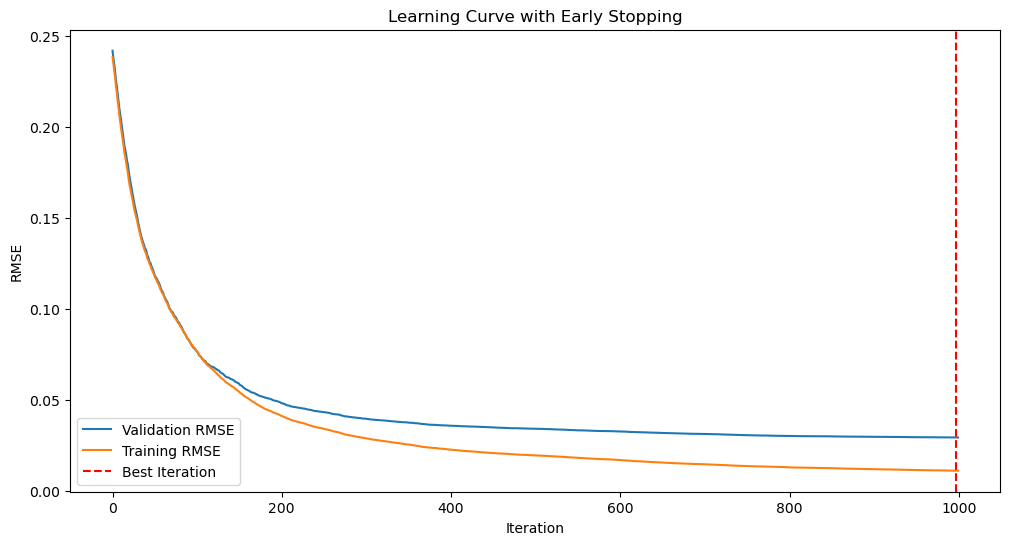

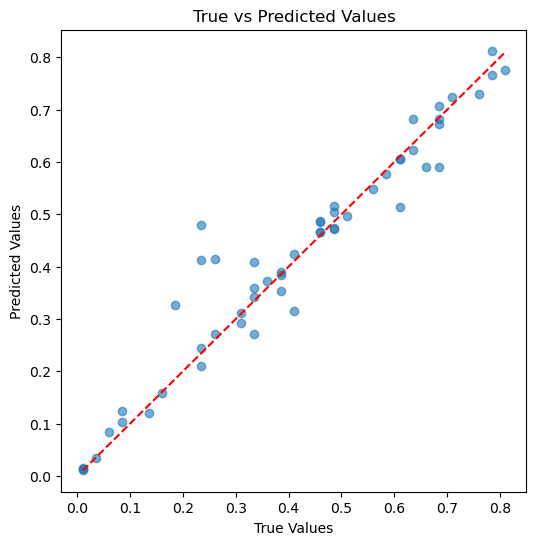

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Features and target
X = df[['VH', 'VV', 'VH_VV_Ratio', 'VV_VH_Ratio', 'VH_VV_Diff', 
         'VV_VH_Diff', 'NDPI', 'DPI', 'SWI', 'VH_corrected', 
         'VV_corrected', 'VH_Squared', 'VV_Squared', 
         'Log_VH']]  # Features
y = df['Moisture']  # Target

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80/20

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Further split training data into training and validation sets for early stopping
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Quick Testing, i am not going to do intesive hyperparameters search
# CatBoost Model for Feature Importance
temp_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=5,
    l2_leaf_reg=4,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_state=42,
    verbose=False
)

# Train on the full training set to get feature importances
temp_model.fit(X_train_scaled, y_train)
feature_importances = temp_model.get_feature_importance()
feature_names = X.columns

# Combine feature names and importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select top 5 features based on importance
top_features = importance_df['Feature'].iloc[:5].tolist()
print(f"Top 5 features: {top_features}")

# Reduce the dataset to top 5 features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Re-scale reduced datasets
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

# Further split the reduced training data for early stopping
X_train_sub_reduced, X_valid_reduced, y_train_sub_reduced, y_valid_reduced = train_test_split(
    X_train_reduced_scaled, y_train, test_size=0.2, random_state=42
)

# CatBoost Model with Early Stopping
model = CatBoostRegressor(
    iterations=1000,  # Allow early stopping to terminate training
    learning_rate=0.05,  # Lower learning rate
    depth=6,  # Shallower trees to reduce complexity
    l2_leaf_reg=10, 
    loss_function='RMSE',
    eval_metric='RMSE',
    random_state=42,
    verbose=False,  # Display training progress
    early_stopping_rounds=50  # Stop if validation RMSE doesn't improve for 50 iterations
)

# Train the model with validation set for early stopping
model.fit(
    X_train_sub_reduced, y_train_sub_reduced,
    eval_set=(X_valid_reduced, y_valid_reduced),  # Validation set
    use_best_model=True,         # Use the best iteration
    verbose=False
)

# Fetch the best iteration
best_iteration = model.get_best_iteration()
print(f"Best iteration: {best_iteration}")

# Evaluate the model on the test set
y_pred = model.predict(X_test_reduced_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error (MSE): {mse:.2f}")
print(f"Test Mean Absolute Error (MAE): {mae:.2f}")
print(f"Test R-squared (R2): {r2:.2f}")

# Plot Learning Curve
evals_result = model.get_evals_result()
plt.figure(figsize=(12, 6))
plt.plot(evals_result['validation']['RMSE'], label='Validation RMSE')
plt.plot(evals_result['learn']['RMSE'], label='Training RMSE')
plt.axvline(best_iteration, color='red', linestyle='--', label='Best Iteration')
plt.title('Learning Curve with Early Stopping')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plot True vs Predicted Values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()
